In [1]:
import pandas as pd 
import numpy as np

import re

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!pip install sagemaker==1.72.0

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


## Load data

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [9]:
from nltk.tokenize import word_tokenize
import re
nltk.download('punkt')
tweet_text = ''.join(train_data['text'])
stop_words = stopwords.words("english")


def clean_text(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]","", string)
    string = re.sub(r"\s{2,}", " ", string)
    
    rm_links = re.sub(r"http\S+", " ", string)
    rm_pn = re.sub(r'[^\w\s]+', ' ', rm_links)
    rm_sc = re.sub('\?|\.|\!|\/|\;|\:', ' ', rm_pn)
    tk = word_tokenize(rm_pn)
    clean_text = [word.lower() for word in tk if word.lower() not in stop_words]
    reformed_text = ' '.join(clean_text)
    return reformed_text

def review_to_words(review):
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    text = clean_text(text)
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = ' '.join([PorterStemmer().stem(w) for w in words]) # stem
    
    return words

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
train_data["clean_text"] = train_data["text"].apply(lambda row:review_to_words(row))
test_data["clean_text"] = test_data["text"].apply(lambda row:review_to_words(row))

## Analyze cleaned text

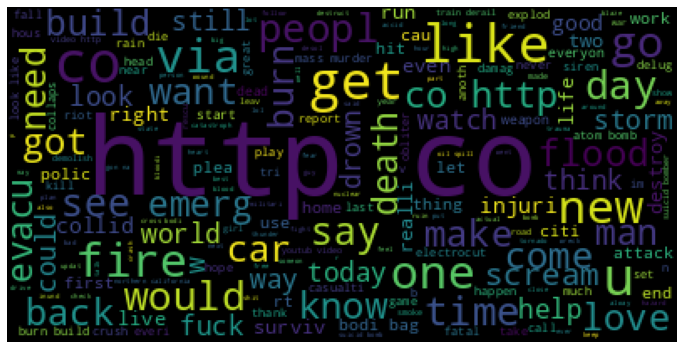

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

xc = ''.join(train_data['clean_text'])
wc = WordCloud(stopwords=stop_words,
              background_color='black',
              max_words=200).generate(xc)


plt.figure(figsize=(12,16))
plt.imshow(wc)
plt.axis('off')
plt.show()

## use TfidfTransformer to generate feature for test and train set

In [12]:
pipe = Pipeline([('count', CountVectorizer()),
                 ('tfid', TfidfTransformer())])
train_feature = pipe.fit_transform(train_data["clean_text"]).toarray()
test_feature = pipe.transform(test_data["clean_text"] ).toarray()

print(train_feature.shape)
print(test_feature.shape)

(7613, 15770)
(3263, 15770)


## Save data to csv file and upload

In [13]:
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session() # Store the current SageMaker session
role = get_execution_role()


In [14]:
import os

data_dir = '../data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## save data to csv file
pd.concat([train_data["target"],pd.DataFrame(train_feature)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)
pd.DataFrame(test_feature).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

# upload to s3
prefix = 'predict-disaster'
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)

## Train the model with XGBoost

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(session.boto_region_name, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [16]:
xgb = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    train_instance_count=1,                  # How many compute instances
                                    train_instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)


xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [17]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
xgb.fit({'train': s3_input_train})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-08-01 12:50:26 Starting - Starting the training job...
2021-08-01 12:50:27 Starting - Launching requested ML instances...
2021-08-01 12:51:19 Starting - Preparing the instances for training.........
2021-08-01 12:52:45 Downloading - Downloading input data...
2021-08-01 12:53:24 Training - Downloading the training image...
2021-08-01 12:53:44 Training - Training image download completed. Training in progress.Arguments: train
[2021-08-01:12:53:45:INFO] Running standalone xgboost training.
[2021-08-01:12:53:45:INFO] Path /opt/ml/input/data/validation does not exist!
[2021-08-01:12:53:45:INFO] File size need to be processed in the node: 459.13mb. Available memory size in the node: 8403.86mb
[2021-08-01:12:53:45:INFO] Determined delimiter of CSV input is ','
[12:53:45] S3DistributionType set as FullyReplicated
[12:53:48] 7613x15770 matrix with 120057010 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[12:53:54] src/tree/updater_prune.cc:74: tree pruni

## Deploy model and predict data on test set

In [18]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
## output values as csv file
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


..............................Arguments: serve
[2021-08-01 13:04:09 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-08-01 13:04:09 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-08-01 13:04:09 +0000] [1] [INFO] Using worker: gevent
[2021-08-01 13:04:09 +0000] [21] [INFO] Booting worker with pid: 21
[2021-08-01 13:04:09 +0000] [22] [INFO] Booting worker with pid: 22
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)', 'urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)']. 
  monkey.patch_all(subprocess=True)
[2021-08-01:

In [21]:

!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

prediction = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
prediction = [round(num) for num in prediction.squeeze().values]

predict = pd.DataFrame(prediction)
predict["id"] = test_data["id"].values
predict["target"] = prediction
predict[["id","target"]].to_csv("predict_boostrap_enhanced.csv", index=False)

download: s3://sagemaker-us-east-1-099005516989/xgboost-2021-08-01-12-59-17-384/test.csv.out to ../data/test.csv.out


## Evaluation

The result is submitted to Kaggle, the score is 0.76677

## Clean resources